In [1]:
import pandas as pd
from pathlib import Path
base_output = Path('group_results')

group_res = {}
group_f = {}

for fp in base_output.rglob('group_stats.csv'):
    group_res[fp.parent.stem] = pd.read_csv(
        fp,
        index_col=0,
        header=[0])
    group_f[fp.parent.stem] = pd.read_csv(
        fp.parent / 'group_fstats.csv',
        index_col=0,
        header=[0])
    
combined_res = {key: pd.concat((group_res[key].loc[:, ['COPE', 'VARCOPE', 'z']] , group_f[key]), axis=1) for key in group_res}


def print_percentage_activations(df):
    mean_activation_df = df.filter(regex='mean_activation', axis=0)
    mean_activation_df.index = mean_activation_df.index.str.replace('_mean_activation','').str.replace('conc_','')
    mean_activation_df = mean_activation_df.drop(['NAA', 'NAAG', 'Cr', 'PCr', 'PCh', 'GPC'])
    mean_activation_df

    constant_df = df.filter(regex='constant', axis=0)
    constant_df.index = constant_df.index.str.replace('_constant','').str.replace('conc_','')
    constant_df = constant_df.drop(['NAA', 'NAAG', 'Cr', 'PCr', 'PCh', 'GPC'])
    constant_df.COPE

    mean_activation_df
    # constant_df
    mean_activation_df.loc[:, ['COPE', 'VARCOPE']] = mean_activation_df.loc[:, ['COPE', 'VARCOPE']].div(constant_df.COPE, axis=0)

    return mean_activation_df.style\
    .format(formatter={
        'COPE': "{:+0.1%}",
        'VARCOPE': "{:+0.2%}",
        'z': "{:+05.2f}",
        'p': "{:05.3f}"})\
    .highlight_between(subset=['p'],left=0, right=0.05, props='font-weight:bold;color:#e83e8c')


In [14]:
def print_percentage_activations_all(all_df):
    out = {}
    for key, df in all_df.items():
        mean_activation_df = df.filter(regex='mean_activation', axis=0)
        mean_activation_df.index = mean_activation_df.index.str.replace('_mean_activation','').str.replace('conc_','')
        mean_activation_df = mean_activation_df.drop(['NAA', 'NAAG', 'Cr', 'PCr', 'PCh', 'GPC'])
        mean_activation_df

        constant_df = df.filter(regex='constant', axis=0)
        constant_df.index = constant_df.index.str.replace('_constant','').str.replace('conc_','')
        constant_df = constant_df.drop(['NAA', 'NAAG', 'Cr', 'PCr', 'PCh', 'GPC'])
        constant_df.COPE

        mean_activation_df
        # constant_df
        mean_activation_df.loc[:, ['COPE', 'VARCOPE']] = mean_activation_df.loc[:, ['COPE', 'VARCOPE']].div(constant_df.COPE, axis=0)
        out[key] = mean_activation_df.loc[:, ['COPE', 'z', 'f-stat', 'zf-stat','p']]
    
    out = pd.concat(out.values(), axis=1, keys=out.keys())

    formatter_dict = {}
    p_list = []
    for key in all_df:
        formatter_dict.update({
            (key, 'COPE'): "{:+0.1%}",
            #(key, 'VARCOPE'): "{:+0.2%}",
            (key, 'z'): "{:+0.2f}",
            (key, 'f-stat'): "{:+0.2f}",
            (key, 'zf-stat'): "{:+0.2f}",
            (key, 'p'): "{:0.1e}"})
        p_list.append((key, 'p'))
    return out.style\
    .format(formatter=formatter_dict)\
    .highlight_between(subset=p_list,left=0, right=0.05, props='font-weight:bold;color:#e83e8c')

print_percentage_activations_all(combined_res)

In [2]:
import numpy as np
group_res['7T_exact_lb'].filter(regex=r'gamma', axis=0).loc[:,['COPE', 'VARCOPE']].div(np.pi)

,COPE,VARCOPE
gamma_0_bold_lb,0.935708,0.000066


In [6]:
group_res['3T_exact_lb'].filter(regex=r'gamma', axis=0).loc[:,['COPE', 'VARCOPE']].div(np.pi)

,COPE,VARCOPE
gamma_0_bold_lb,1.254033,0.000331


In [10]:
group_res['7T_exact_lb'].filter(regex='gamma', axis=0)

,COPE,VARCOPE,z,p
gamma_0_bold_lb,2.939614,0.000208,27.097242,5.305721e-162


In [11]:
group_res['3T_exact_lb'].filter(regex='gamma', axis=0)

,COPE,VARCOPE,z,p
gamma_0_bold_lb,3.93966,0.001041,24.592104,7.672199e-134


## Cohen's d

In [3]:
to_drop = ['NAA', 'NAAG', 'Cr', 'PCr', 'PCh', 'GPC', 'Ala', 'Gly', 'Lip09', 'Lip13a', 'Lip13b', 'Lip20']

def calc_cohens_d(all_df):
    out = {}
    for key, df in all_df.items():
        mean_activation_df = df.filter(regex='mean_activation', axis=0)
        mean_activation_df.index = mean_activation_df.index.str.replace('_mean_activation','').str.replace('conc_','')
        mean_activation_df = mean_activation_df.drop(to_drop)
        
        # calculate SD from variance
        mean_activation_df.loc[:,'SDCOPE'] = mean_activation_df.VARCOPE.pow(0.5)

        # Calculate Cohens d
        mean_activation_df.loc[:,'Cohens_d'] = mean_activation_df.COPE.div(mean_activation_df.SDCOPE)

        constant_df = df.filter(regex='constant', axis=0)
        constant_df.index = constant_df.index.str.replace('_constant','').str.replace('conc_','')
        constant_df = constant_df.drop(to_drop)

        mean_activation_df.loc[:, ['COPE', 'VARCOPE']] = mean_activation_df.loc[:, ['COPE', 'VARCOPE', 'SDCOPE']].div(constant_df.COPE, axis=0)
        out[key] = mean_activation_df.loc[:, ['COPE', 'SDCOPE', 'Cohens_d']]
    
    return pd.concat(out.values(), axis=1, keys=out.keys())

def print_cohensd_all(all_df):
    formatter_dict = {}
    for key in results_df.columns.get_level_values(0).unique():
        formatter_dict.update({
            (key, 'COPE'): "{:+0.1%}",
            (key, 'SDCOPE'): "{:0.3%}",
            (key, 'Cohens_d'): "{:0.3f}"})

    return all_df.style\
        .format(formatter=formatter_dict)

results_df = calc_cohens_d(combined_res)

print_cohensd_all(results_df)

In [88]:
to_plot_cd = results_df.loc[:,(slice(None), ['Cohens_d', 'COPE'])]
to_plot_cd = to_plot_cd.melt(ignore_index=False).reset_index(names=['Metabolite'])

#  Split into field strength and model
to_plot_cd[['Field', 'Model', 'tmp']] = to_plot_cd.variable_0.str.split('_', expand=True)
to_plot_cd = to_plot_cd.drop(['variable_0', 'tmp'], axis=1)
to_plot_cd = to_plot_cd.rename(columns = {'variable_1':'value_type'})

# Abs for Cohen's d and percentage for COPE
cd_index = to_plot_cd.value_type=="Cohens_d"
to_plot_cd.loc[cd_index, "value"] = to_plot_cd.loc[cd_index, "value"].abs()
to_plot_cd.loc[~cd_index, "value"] = to_plot_cd.loc[~cd_index, "value"] * 100.0
to_plot_cd

,Metabolite,value_type,value,Field,Model
0,Asc,Cohens_d,1.697265,7T,correct
1,Asp,Cohens_d,4.143124,7T,correct
2,GABA,Cohens_d,2.424129,7T,correct
3,GSH,Cohens_d,0.754684,7T,correct
4,Glc,Cohens_d,0.723469,7T,correct
...,...,...,...,...,...
247,sIns,COPE,-0.367660,3T,fixed
248,NAA+NAAG,COPE,2.224891,3T,fixed
249,Cr+PCr,COPE,2.538400,3T,fixed
250,PCh+GPC,COPE,2.534828,3T,fixed


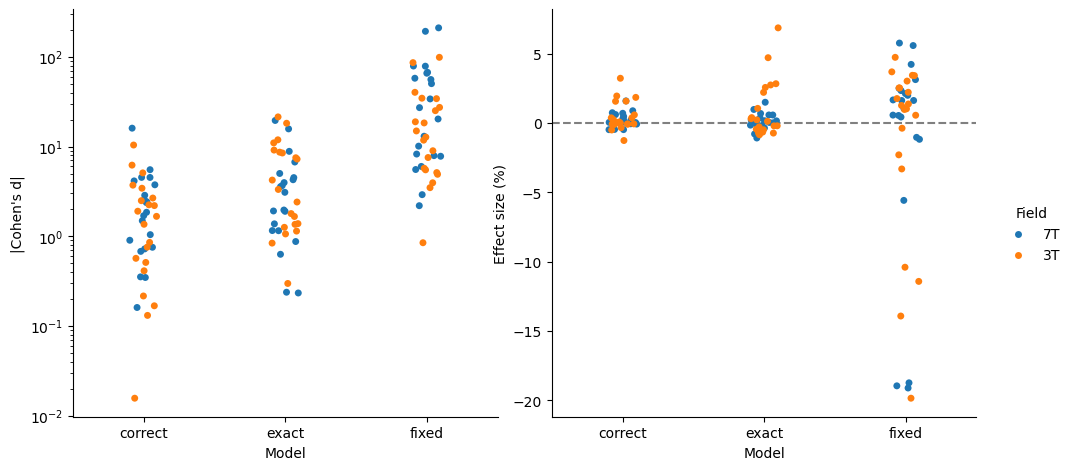

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt


effect_plot=sns.catplot(
    data=to_plot_cd,
    kind='strip',
    x='Model',
    hue='Field',
    y="value",
    log_scale=False,
    col="value_type",
    sharey=False
)
effect_plot.refline(y=0)
_ = effect_plot.axes.flat[0].set(yscale="log")
_ = effect_plot.axes.flat[1].set(ylabel="Effect size (%)")
_ = effect_plot.axes.flat[0].set(ylabel="|Cohen's d|")
_ = effect_plot.axes.flat[0].set(title="")
_ = effect_plot.axes.flat[1].set(title="")
# plt.ylim(-20, 10)

effect_plot.savefig("figures/dynamic_effect_size.png", dpi=600, bbox_inches="tight") 